# Modeling fish production, using Stock et al. 2017 equations. 
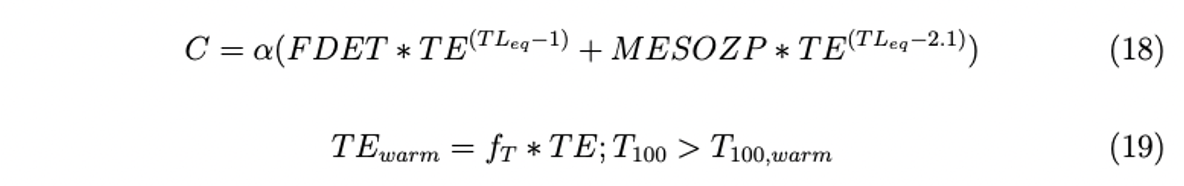

__{$\alpha$}__ = harvesting factor interpreted as the fraction of energy available at TL$_{eq}$ that is realized as catch

* in Stock et al. 2017, single values of TE and $\alpha$  are fit across LMEs such that any interregional variation in these parameters would appear as unexplained catch variance

* __{$\alpha$} was constrained between 0 and 1.__ 

__FDET__ = energy available from the plankton food web via the flux of detritus to sediment 

__TE__ = trophic transfer efficincy, controlling the decay of energy between trophic levels. This is a dimensionless free paramter controlling the decay of energy between trophic levels. 

* __values of TE were constrained within typical observed ranges of 0-0.4__
    * (Pauly D, Christensen V (1995) Primary production required to sustain global fisheries. Nature 374(6519):255–257.)
    * Libralato S, Coll M, Tudela S, Palomera I, Pranovi F (2008) Novel index for quantification of ecosystem effects of fishing as removal of secondary production. Mar Ecol Prog Ser 355:107–129.

__TL$_{eq}$__ = equivalent trophic level of the aggreagte catch derived from FishBase. It scaled by a trophic level of 1 for FDET and 2.1 for MESOZP from the fish catch. 

* Phytoplankton are assigned to trophic level 1, such that TL$_{eq}$ - 1 is the number of trophic steps separating phytoplankton from the fish catch.  

__MESOZP__ = mesozooplankton production not consumed by other zooplankton


In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [4]:
### All 63 years of the 2nd cycle 
newNCDFfiles1 = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/SPECTRA_*.nc', recursive=True),
                      key=numericalSort)

ds_01 = xr.open_mfdataset(newNCDFfiles1,combine='by_coords')

In [5]:
POC_ds_inter = np.empty([63,12,60,384,320])
POC_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    POC_ds_inter[i,:,:,:,:] = ds_01.POC_FLUX_IN[x[i]:x[i]+12,:,:,:]

In [6]:
POC_ds_inter.shape

(63, 12, 60, 384, 320)

In [7]:
KMT_ds_inter = np.empty([63,12,384,320])
KMT_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    KMT_ds_inter[i,:,:,:] = ds_01.KMT[x[i]:x[i]+12,:,:]

### __FDET__ = energy available from the plankton food web via the flux of detritus to sediment 

Flux = np.nanmean(POC_ds_inter[:,:,:,:,:],axis=1) * (60*60*24*365)/100 * 12.011 / 1e3 # mmol/m^3 cm/s --> mmol/m^2/y ----> g/m^2/y

kmt_bottom = np.nanmean(KMT_ds_inter,axis=(0,1))
flux_bottom_62yr_avg = np.empty([63,12,384,320]) # Size of the array that I need
flux_bottom_62yr_avg[:] = np.nan # make everything a nan inside of it
for i in range(384): # loop through the latitude 
    for j in range(320): # loop through the longitude 
        # For each lat and lon, find the bottom depth, and select that flux as the bottom flux of each grid cell. 
        # I averaged the bottom depth annually before becuase I do not expect the bottom depth to change seasonally right?
        if kmt_bottom[i,j] == 0: 
            flux_bottom_62yr_avg[:,:,i,j] =  POC_ds_inter[:,:,0,i,j]# mmol/m^3 cm/s
        else:
            flux_bottom_62yr_avg[:,:,i,j] =  POC_ds_inter[:,:,np.int(kmt_bottom[i,j])-1,i,j]# mmol/m^3 cm/s
        

np.save("/glade/scratch/gabyn/SPECTRA/flux_bottom_62yr_avg.npy",flux_bottom_62yr_avg)

In [9]:
flux_bottom = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/flux_bottom_62yr_avg.npy")

In [10]:
flux_bottom.shape

(63, 12, 384, 320)

In [11]:
flux_bottom_depth = flux_bottom * (60*60*24*365)/100 * 12.011 / 1e3 #g/m^2/y

In [12]:
flux_bottom_depth.shape

(63, 12, 384, 320)

### Compare FDET/NPP with Stock et al. 2017

In [13]:
photoC_TOT_ds_inter = np.empty([63,12,15,384,320])
photoC_TOT_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    photoC_TOT_ds_inter[i,:,:,:,:] = ds_01.photoC_TOT[x[i]:x[i]+12,:,:,:]

In [14]:
photoC_TOT_ds_inter.shape

(63, 12, 15, 384, 320)

In [15]:
total_npp = np.nansum(photoC_TOT_ds_inter,axis=2) * 10 # (10 = depth of each layer) integrate over depth mmol/m^3/s to #mmol m-2 s-1
total_npp = np.nanmean(total_npp,axis=1) * (60*60*24*365) # mmol m-2 y-1
total_npp = total_npp * 12.011 / 1e3 # g/m^2/y

KeyboardInterrupt: 

In [ ]:
total_npp.shape

In [ ]:
fig = plt.figure(figsize=(15, 7))
lev = np.arange(0, 400, 20)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=200)
lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(total_npp,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('62 yr avg NPP (g/m$^2$/y)', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(15, 7))
lev = np.arange(0, 64, 2)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=32)
lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(flux_bottom_depth,axis=(0,1)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('62 yr avg FDET (g/m$^2$/y)', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

In [ ]:
month = ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig = plt.figure(figsize=(20, 20))
lev = np.arange(0, 30, 2)
for i in range(12): 
    norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=15)
    lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(flux_bottom_depth[:,i,:,:],axis=0))
    ax = fig.add_subplot(4, 4, i+1, projection=ccrs.Robinson(central_longitude=305.0))
    cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm,extend = 'max', transform=ccrs.PlateCarree());
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
    ax.set_global()
    cb.ax.set_title(''+month[i]+' FDET (g/m$^2$/y)', fontsize = 16)
    cb.ax.tick_params(labelsize=16)
    fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(15, 7))
lev = np.arange(0, 0.18, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.09)
lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(flux_bottom_depth,axis=(0,1))/np.nanmean(total_npp,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_global()
cb.ax.set_title('FDET/NPP', fontsize = 16)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

### __MESOZP__ = mesozooplankton production not consumed by other zooplankton
* Here, I will use zooplankton production - zooplankton grazing on zooplankton of each category

In [ ]:
ds_01.x_graze_zoo3_zint.shape

In [ ]:
x_graze_zoo3_zint_ds_inter = np.empty([63,12,384,320])
x_graze_zoo4_zint_ds_inter = np.empty([63,12,384,320])
x_graze_zoo5_zint_ds_inter = np.empty([63,12,384,320])
x_graze_zoo6_zint_ds_inter = np.empty([63,12,384,320])
x_graze_zoo3_zint_ds_inter[:] = np.nan
x_graze_zoo4_zint_ds_inter[:] = np.nan
x_graze_zoo5_zint_ds_inter[:] = np.nan
x_graze_zoo6_zint_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    x_graze_zoo3_zint_ds_inter[i,:,:,:] = ds_01.x_graze_zoo3_zint[x[i]:x[i]+12,:,:]
    x_graze_zoo4_zint_ds_inter[i,:,:,:] = ds_01.x_graze_zoo4_zint[x[i]:x[i]+12,:,:]
    x_graze_zoo5_zint_ds_inter[i,:,:,:] = ds_01.x_graze_zoo5_zint[x[i]:x[i]+12,:,:]
    x_graze_zoo6_zint_ds_inter[i,:,:,:] = ds_01.x_graze_zoo6_zint[x[i]:x[i]+12,:,:]

In [ ]:
x_graze_zoo3_zint_ds_inter.shape

In [ ]:
ds_01.zoo3_linear_loss_zint_100m.shape

In [ ]:
zoo3_linear_loss_zint_100m_ds_inter = np.empty([63,12,384,320])
zoo4_linear_loss_zint_100m_ds_inter = np.empty([63,12,384,320])
zoo5_linear_loss_zint_100m_ds_inter = np.empty([63,12,384,320])
zoo6_linear_loss_zint_100m_ds_inter = np.empty([63,12,384,320])
zoo3_linear_loss_zint_100m_ds_inter[:] = np.nan
zoo4_linear_loss_zint_100m_ds_inter[:] = np.nan
zoo5_linear_loss_zint_100m_ds_inter[:] = np.nan
zoo6_linear_loss_zint_100m_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    zoo3_linear_loss_zint_100m_ds_inter[i,:,:,:] = ds_01.zoo3_linear_loss_zint_100m[x[i]:x[i]+12,:,:]
    zoo4_linear_loss_zint_100m_ds_inter[i,:,:,:] = ds_01.zoo4_linear_loss_zint_100m[x[i]:x[i]+12,:,:]
    zoo5_linear_loss_zint_100m_ds_inter[i,:,:,:] = ds_01.zoo5_linear_loss_zint_100m[x[i]:x[i]+12,:,:]
    zoo6_linear_loss_zint_100m_ds_inter[i,:,:,:] = ds_01.zoo6_linear_loss_zint_100m[x[i]:x[i]+12,:,:]

In [ ]:
zooGraz = np.stack([x_graze_zoo3_zint_ds_inter,x_graze_zoo4_zint_ds_inter,x_graze_zoo5_zint_ds_inter,x_graze_zoo6_zint_ds_inter])

In [ ]:
zooGraz.shape

In [ ]:
zooGraz_TOT = np.nansum(zooGraz,axis=0)* 1e-2 *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [ ]:
zooGraz_TOT.shape

In [ ]:
zooLoss = np.stack([zoo3_linear_loss_zint_100m_ds_inter,zoo4_linear_loss_zint_100m_ds_inter,zoo5_linear_loss_zint_100m_ds_inter,zoo6_linear_loss_zint_100m_ds_inter])
zooloss_TOT= np.nansum(zooLoss,axis=0)* 1e-2 *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

In [ ]:
zooloss_TOT.shape

# sum of Mesozooplankton Grazing Gain Vertical Integral mol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooGraz'] = xr.concat([ds['x_graze_' + v + '_zint'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooGraz_TOT = ds.zooGraz *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

# zooplankton Linear loss vertical Intergral mmol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooLoss'] = xr.concat([ds[''+ v + '_linear_loss_zint_100m'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooloss_TOT = ds.zooLoss *(60*60*24*365) * 1.2011e-2 # to g C / m^2 y

### ds.zoo1_linear_loss_zint_100m OR ds.zoo1_linear_loss_zint
* max zoo production with zoo1_linear_loss_zint_100m is 54.58, and min is -1.4
* max zoo production with zoo1_linear_loss_zint is 45.77, and min is -7.14

In [ ]:
zooProduction = np.subtract(zooGraz_TOT, zooloss_TOT)
zooProduction_updated = np.where(zooProduction<0, 0, zooProduction)

In [ ]:
np.nanmin(zooProduction_updated)

In [ ]:
np.nanmax(zooProduction_updated)

In [ ]:
lev = np.arange(0, 40, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=20)

fig = plt.figure(figsize=(10, 7.5))
lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(zooProduction_updated,axis=(0,1)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('gC $m^{-2}$ $y^{-1}$')
ax.set_title('62 yr avg Mesozooplankton Production');
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(20, 20))
lev = np.arange(0, 40, 1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=20)
for i in range(12): 
    lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(zooProduction_updated[:,i,:,:],axis=0))
    ax = fig.add_subplot(4, 4, i+1, projection=ccrs.Robinson(central_longitude=305.0))
    cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'max',transform=ccrs.PlateCarree());
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
    cb.ax.set_title('gC $m^{-2}$ $y^{-1}$')
    ax.set_title(''+month[i]+' Mesozoo Prod');
    plt.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/MESOZP_seasonal_62yravg.png',dpi=200, bbox_inches='tight')

In [ ]:
# Mesozooplankton production.. 
zoo3_prod = np.subtract(x_graze_zoo3_zint_ds_inter, zoo3_linear_loss_zint_100m_ds_inter)
zoo4_prod = np.subtract(x_graze_zoo4_zint_ds_inter, zoo4_linear_loss_zint_100m_ds_inter)
zoo5_prod = np.subtract(x_graze_zoo5_zint_ds_inter, zoo5_linear_loss_zint_100m_ds_inter)
zoo6_prod = np.subtract(x_graze_zoo6_zint_ds_inter, zoo6_linear_loss_zint_100m_ds_inter)

In [ ]:
fig = plt.figure(figsize=(15, 10))
lev = np.arange(0, 0.12, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.06)
lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(zooProduction_updated,axis=(0,1))/np.nanmean(total_npp,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('MESOZP/NPP')
ax.set_title('MESOZP/NPP');

### Grazing flux based on trophic level 

In [ ]:
## Gaby's Path 
jluo_path = '/glade/u/home/jluo/cesm_scripts/size_structured/nl_input/cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
gabyn_path = '/glade/u/home/gabyn/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+'GNG595/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')
sizes

In [ ]:
ZooTL_g = np.load("zoo_mean_TL.npy") # this might not be the 62 yr avg and instead the 20 yr avg, so I will have to redo this eventually! 

In [ ]:
ZooTL_g.shape

In [ ]:
fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(ZooTL_g,axis=(0,1)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zoo TL')
ax.set_title('Zooplankton Mean Trophic Level (top 150m)');

### Calculating fish Catch 

In [ ]:
alpha = 0.5 # ranges from 0 to 1 
FDET = np.nanmean(flux_bottom_depth,axis=(0,1)) # POC Flux into Cell (mmol/m^3 cm/s) to g C / m^2 s
TE = 0.2 # ranges from 0 to 0.4 
TE_eq = 2 # trophic level (np.nanmean(ZooTL_g,axis=(0,1,2,3))) ---> (2.5885172746837832)
MESOZP =  np.nanmean(zooProduction_updated,axis=(0,1)) # g C / m^2 s

### Let's make sure that this equation is showing everything correctly! 

In [ ]:
Catch = alpha*((FDET*TE**(TE_eq-1))+(MESOZP*TE**(TE_eq-np.nanmean(ZooTL_g,axis=(0,1,2,3)))))

In [ ]:
fig = plt.figure(figsize=(15, 10))
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, Catch)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10),transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, extend = 'both',orientation='horizontal')
cb.ax.set_title('Annual Fish Catch', fontsize=16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/annual_catch_global_TLeq2_2_6_62yravg.png',dpi=200, bbox_inches='tight')

## Seasonal Fish Catch! 

In [ ]:
alpha = 0.5 # ranges from 0 to 1 
FDET = flux_bottom_depth # POC Flux into Cell (mmol/m^3 cm/s) to g C / m^2 s
TE = 0.2 # ranges from 0 to 0.4 
TE_eq = 2 # trophic level 
MESOZP =  zooProduction_updated # g C / m^2 s

In [ ]:
ZooTL_g.shape

In [ ]:
Catch_monthly_62yr = np.empty([63,12,384,320])
Catch_monthly_62yr[:]= np.nan
for i in range(12):
    for j in range(63):
        Catch_monthly_62yr[j,i,:,:] = alpha*((FDET[j,i,:,:]*TE**(TE_eq-1))+(MESOZP[j,i,:,:]*TE**(TE_eq-np.nanmean(ZooTL_g[i,:,:,:],axis=(0,1,2)))))

In [ ]:
np.save("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/Catch_monthly_62yr.npy",Catch_monthly_62yr)

In [ ]:
np.nanmin(MESOZP)

In [ ]:
label = ['01','02','03','04','05','06','07','08','09','10','11','12']
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
for i in range(12):
    print(''+months[i]+' Fish Catch')

lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
label = ['01','02','03','04','05','06','07','08','09','10','11','12']

for i in range(12): 
    fig = plt.figure(figsize=(15, 10))
    lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(Catch_monthly_62yr[:,i,:,:],axis=0))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
    cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.0001, vmax=10),transform=ccrs.PlateCarree());
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
    cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
    cb.ax.set_title(''+months[i]+' Fish Catch', fontsize=16)
    fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/0'+label[i]+'_catch_global_TLeq2_62yr.png',dpi=200, bbox_inches='tight')

## Create a subplot figure that has January, April, July and October with trophic level 2 on top, and trophic level 3 on the bottom, it should be 2 by 4. 

In [ ]:
alpha = 0.5 # ranges from 0 to 1 
FDET = flux_bottom_depth # POC Flux into Cell (mmol/m^3 cm/s) to g C / m^2 s
TE = 0.2 # ranges from 0 to 0.4 
TE_eq = 3 # trophic level 
MESOZP =  zooProduction_updated # g C / m^2 s

In [ ]:
Catch_monthly_TLeq3_62yr = np.empty([63,12,384,320])
Catch_monthly_TLeq3_62yr[:]= np.nan
for i in range(12):
    for j in range(63):
        Catch_monthly_TLeq3_62yr[j,i,:,:] = alpha*((FDET[j,i,:,:]*TE**(TE_eq-1))+(MESOZP[j,i,:,:]*TE**(TE_eq-np.nanmean(ZooTL_g[i,:,:,:],axis=(0,1,2)))))

In [ ]:
np.save("/glade/scratch/gabyn/SPECTRA/Catch_monthly_TLeq3_62yr.npy",Catch_monthly_TLeq3_62yr)

lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
label = ['01','02','03','04','05','06','07','08','09','10','11','12']

for i in range(12): 
    fig = plt.figure(figsize=(15, 10))
    lon, lat, zoo = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(Catch_monthly_TLeq3_62yr[:,i,:,:],axis=0))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
    cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.0001, vmax=10),transform=ccrs.PlateCarree());
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
    cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
    cb.ax.set_title(''+months[i]+' Fish Catch', fontsize=16)
    fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/0'+label[i]+'_catch_global_TLeq3_62yr.png',dpi=200, bbox_inches='tight')

## Create, Winter, Spring, Summer, Fall plots for fish catch in trophic level 2, and then the differences between temperature, ice and nutrients. 

In [5]:
Catch_monthly_TLeq3_62yr = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/Catch_monthly_TLeq3_62yr.npy")

### High vs Low temperature years

In [6]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [7]:
temp_ds_inter = np.empty([63,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    temp_ds_inter[i,:,:,:] = ds.TEMP[x[i]:x[i]+12,0,:,:]

In [8]:
temp_arctic = np.nanmean(temp_ds_inter[:,:,149:180,:], axis=(2,3))
temp_arctic_anom = temp_arctic-np.nanmean(temp_arctic,axis=0)
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
cold_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) < -(err_ao/2))
warm_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) > (err_ao/2))

In [9]:
cold_years_arctic

(array([16, 17, 18, 19, 20, 21, 22, 23, 25, 28, 29, 31, 35, 36, 39, 40, 42,
        45, 49]),)

In [10]:
cold_years = Catch_monthly_TLeq3_62yr[cold_years_arctic,:,:,:] # 1/2 standard deviation 
warm_years = Catch_monthly_TLeq3_62yr[warm_years_arctic,:,:,:] # 1/2 standard deviation 

In [11]:
cold_years.shape

(1, 19, 12, 384, 320)

### High vs low Ice Fraction Years 

In [12]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [13]:
ECOSYS_IFRAC_ds_inter = np.empty([63,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [14]:
ice_arctic = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:180,:], axis=(2,3))
ice_arctic_anom = ice_arctic-np.nanmean(ice_arctic,axis=0)
err_ao = np.nanstd(ice_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) < -(err_ao/2))
high_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) > (err_ao/2))

In [15]:
low_ice_years = Catch_monthly_TLeq3_62yr[low_ice_years_arctic,:,:,:] # 1/2 standard deviation 
high_ice_years = Catch_monthly_TLeq3_62yr[high_ice_years_arctic,:,:,:] # 1/2 standard deviation 

### High vs low Nutrient years

In [16]:
NO3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_NO3*.nc', recursive=True))
ds= xr.open_mfdataset(NO3_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [17]:
NO3_ds_inter = np.empty([63,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    NO3_ds_inter[i,:,:,:] = ds.NO3[x[i]:x[i]+12,0,:,:]

In [18]:
no3_arctic = np.nanmean(NO3_ds_inter[:,:,149:180,:], axis=(2,3))
no3_arctic_anom = no3_arctic-np.nanmean(no3_arctic,axis=0)
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) < -(err_ao/2))
high_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) > (err_ao/2))

In [19]:
low_no3_years = Catch_monthly_TLeq3_62yr[low_no3_years_arctic,:,:,:] # 1/2 standard deviation 
high_no3_years = Catch_monthly_TLeq3_62yr[high_no3_years_arctic,:,:,:] # 1/2 standard deviation 

## Crete subplot figure!! 

In [20]:
Catch_monthly_TLeq3_62yr.shape

(63, 12, 384, 320)

In [21]:
np.nanmean(cold_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)).shape

(384, 320)

In [22]:
winter_temp_diff = ((np.nanmean(cold_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2))-np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))/np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))*100

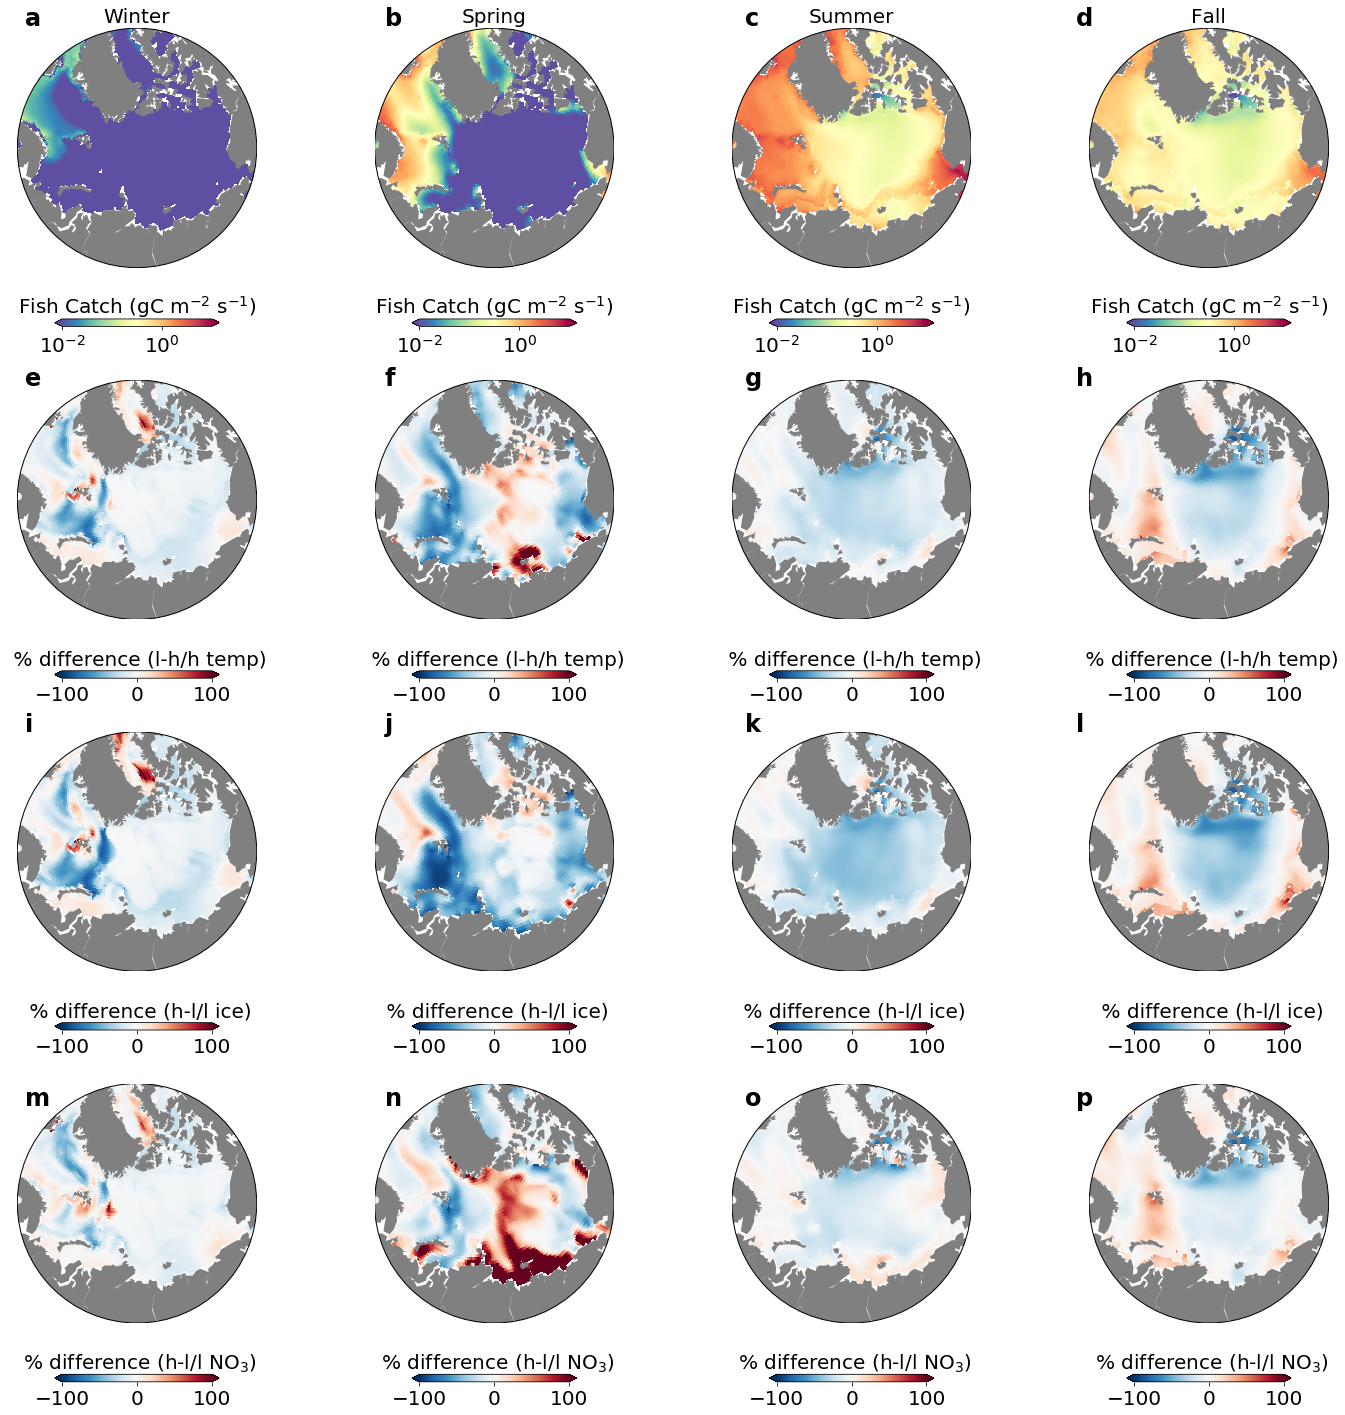

In [28]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))

#### 62 year average!!! 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, Catch_monthly_TLeq3_62yr[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =20)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(4, 4, 2)
lon, lat, spring = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, Catch_monthly_TLeq3_62yr[:,2:5,:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =20)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 3)
lon, lat, summer = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, Catch_monthly_TLeq3_62yr[:,5:8,:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=20)
ax.set_title('Summer', fontsize =20)
cb.ax.tick_params(labelsize=20)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 4)
lon, lat, fall = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, Catch_monthly_TLeq3_62yr[:,8:11,:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=20)
ax.set_title('Fall', fontsize =20)
cb.ax.tick_params(labelsize=20)

########## Differences!!! 

# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = ((np.nanmean(cold_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2))-np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))/np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, winter_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (l-h/h temp)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = ((np.nanmean(cold_years[:,:,2:5,:,:], axis=(0,1,2))-np.nanmean(warm_years[:,:,2:5,:,:], axis=(0,1,2)))/np.nanmean(warm_years[:,:,2:5,:,:], axis=(0,1,2)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, spring_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (l-h/h temp)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = ((np.nanmean(cold_years[:,:,5:8,:,:], axis=(0,1,2))-np.nanmean(warm_years[:,:,5:8,:,:], axis=(0,1,2)))/np.nanmean(warm_years[:,:,5:8,:,:], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, summer_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (l-h/h temp)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = ((np.nanmean(cold_years[:,:,8:11,:,:], axis=(0,1,2))-np.nanmean(warm_years[:,:,8:11,:,:], axis=(0,1,2)))/np.nanmean(warm_years[:,:,8:11,:,:], axis=(0,1,2)))*100
lon, lat, f_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, fall_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (l-h/h temp)', fontsize=20)
cb.ax.tick_params(labelsize=20)

## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 9)
winter_ice_diff = ((np.nanmean(high_ice_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, winter_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 10)
spring_ice_diff = ((np.nanmean(high_ice_years[:,:,2:5,:,:], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,2:5,:,:], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,2:5,:,:], axis=(0,1,2)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, spring_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 11)
summer_ice_diff = ((np.nanmean(high_ice_years[:,:,5:8,:,:], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,5:8,:,:], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,5:8,:,:], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, summer_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 12)
fall_ice_diff = ((np.nanmean(high_ice_years[:,:,8:11,:,:], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,8:11,:,:], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,8:11,:,:], axis=(0,1,2)))*100
lon, lat, f_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, fall_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)


# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = ((np.nanmean(high_no3_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = ((np.nanmean(high_no3_years[:,:,2:5,:,:], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,2:5,:,:], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,2:5,:,:], axis=(0,1,2)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, spring_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = ((np.nanmean(high_no3_years[:,:,5:8,:,:], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,5:8,:,:], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,5:8,:,:], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, summer_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = ((np.nanmean(high_no3_years[:,:,8:11,:,:], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,8:11,:,:], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,8:11,:,:], axis=(0,1,2)))*100
lon, lat, f_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, fall_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='horizontal')
cb.ax.tick_params(labelsize=20)
cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)

fig.text(0.05, 0.98, 'a',fontsize=24, fontweight='bold')
fig.text(0.3, 0.98, 'b',fontsize=24, fontweight='bold')
fig.text(0.55, 0.98, 'c',fontsize=24, fontweight='bold')
fig.text(0.78, 0.98, 'd',fontsize=24, fontweight='bold')
fig.text(0.05, 0.73, 'e',fontsize=24, fontweight='bold')
fig.text(0.3, 0.73, 'f',fontsize=24, fontweight='bold')
fig.text(0.55, 0.73, 'g',fontsize=24, fontweight='bold')
fig.text(0.78, 0.73, 'h',fontsize=24, fontweight='bold')
fig.text(0.05, 0.49, 'i',fontsize=24, fontweight='bold')
fig.text(0.3, 0.49, 'j',fontsize=24, fontweight='bold')
fig.text(0.55, 0.49, 'k',fontsize=24, fontweight='bold')
fig.text(0.78, 0.49, 'l',fontsize=24, fontweight='bold')
fig.text(0.05, 0.23, 'm',fontsize=24, fontweight='bold')
fig.text(0.3, 0.23, 'n',fontsize=24, fontweight='bold')
fig.text(0.55, 0.23, 'o',fontsize=24, fontweight='bold')
fig.text(0.78, 0.23, 'p',fontsize=24, fontweight='bold')

plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/quarterly_catch_AO_TLeq3_diff.png',dpi=600, bbox_inches='tight')

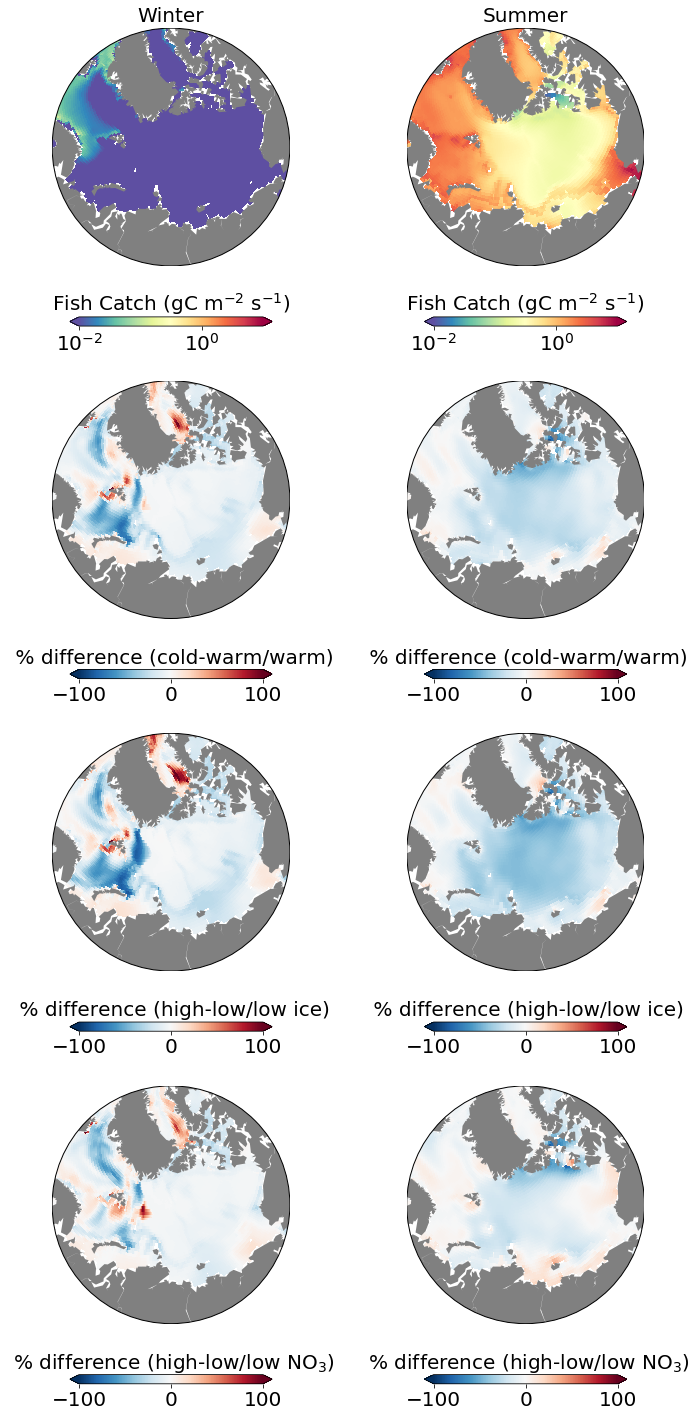

In [27]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 1, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(10, 20))

#### 62 year average!!! 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 2, 1)
lon, lat, winter = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, Catch_monthly_TLeq3_62yr[:,list(range(2)) + [-1],:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =20)



# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 2, 2)
lon, lat, summer = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, Catch_monthly_TLeq3_62yr[:,5:8,:,:].mean(axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r',norm=colors.LogNorm(vmin=0.01, vmax=10));
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title('Fish Catch (gC m$^{-2}$ s$^{-1}$)', fontsize=20)
ax.set_title('Summer', fontsize =20)
cb.ax.tick_params(labelsize=20)


########## Differences!!! 

# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 2, 3)
winter_temp_diff = ((np.nanmean(cold_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2))-np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))/np.nanmean(warm_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, winter_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)



# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 2, 4)
summer_temp_diff = ((np.nanmean(cold_years[:,:,5:8,:,:], axis=(0,1,2))-np.nanmean(warm_years[:,:,5:8,:,:], axis=(0,1,2)))/np.nanmean(warm_years[:,:,5:8,:,:], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, summer_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
cb.ax.tick_params(labelsize=20)



## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 2, 5)
winter_ice_diff = ((np.nanmean(high_ice_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, winter_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (high-low/low ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)



# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 2, 6)
summer_ice_diff = ((np.nanmean(high_ice_years[:,:,5:8,:,:], axis=(0,1,2))-np.nanmean(low_ice_years[:,:,5:8,:,:], axis=(0,1,2)))/np.nanmean(low_ice_years[:,:,5:8,:,:], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, summer_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (high-low/low ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)



# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 2, 7)
winter_no3_diff = ((np.nanmean(high_no3_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,list(range(2)) + [-1],:,:], axis=(0,1,2)))*100
lon, lat, w_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (high-low/low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)



# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 2, 8)
summer_no3_diff = ((np.nanmean(high_no3_years[:,:,5:8,:,:], axis=(0,1,2))-np.nanmean(low_no3_years[:,:,5:8,:,:], axis=(0,1,2)))/np.nanmean(low_no3_years[:,:,5:8,:,:], axis=(0,1,2)))*100
lon, lat, s_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, summer_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=-100,vmax=100);
cb = plt.colorbar(cf, shrink=0.75, extend ='both',orientation='horizontal')
cb.ax.set_title(' % difference (high-low/low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)



plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/quarterly_catch_AO_TLeq3_diff_comittee_meeting.png',dpi=600, bbox_inches='tight')